Welcome to the National Water Model (NWM) Sandbox! This Jupyter Notebook contains Python functions that will allow you to explore NWM forecasts for any river segment covered by the NWM. Execute each cell in the order that they appear and read the comments and notes that are included along the way.

The next cell installs or imports all of the modules or packages that will be used in this notebook.

In [6]:
!pip install netcdf4
!pip install geoglows -q
from datetime import date
import os
import geoglows
import requests
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, DayLocator

#Set-up inline plots using matplotlib
%matplotlib inline

The next code cell defines all of the functions that are used in the notebook. Short descriptions are provided next to each function. Try to understand how they work by reading through the code.

In [7]:
#This function builds a file name for a specific forecast from the NOAA NWM http file delivery web site like this one:
#https://nomads.ncep.noaa.gov/pub/data/nccf/com/nwm/prod/nwm.20210320/short_range/nwm.t00z.short_range.channel_rt.f001.conus.nc
def GetForecastFileName(ForecastStartDate = '20210321', ForecastStartTimestep='00', ForecastType = 'short_range', ForecastMember='1', TimeStep = '001'):
  BaseName = 'https://nomads.ncep.noaa.gov/pub/data/nccf/com/nwm/prod/nwm.'

  #ForecastStartDate = date.today.strftime('%Y%m%d')
  ForecastStartDate

  if (ForecastType == 'short_range'):
    return BaseName + ForecastStartDate + '/short_range/nwm.t' + ForecastStartTimestep +'z.short_range.channel_rt.f' + TimeStep + '.conus.nc'
  elif (ForecastType == 'medium_range'): 
    return BaseName + ForecastStartDate + '/medium_range_mem' + ForecastMember + '/nwm.t' + ForecastStartTimestep +'z.medium_range.channel_rt_' + ForecastMember + '.f' + TimeStep + '.conus.nc'
  elif (ForecastType == 'long_range'):
    return BaseName + ForecastStartDate + '/long_range_mem' + ForecastMember + '/nwm.t' + ForecastStartTimestep +'z.long_range.channel_rt_' + ForecastMember + '.f' + TimeStep + '.conus.nc'
  else:
    return 'error'


#This function checks if a url is valid
def ValidUrl(url = 'https://nomads.ncep.noaa.gov/pub/data/nccf/com/nwm/prod/nwm.20210321/short_range/nwm.t00z.short_range.channel_rt.f001.conus.nc'):
  request = requests.get(url)
  if request.status_code == 200:
    return True
  else:
    return False 


#This function downloads the appropriate forecast's file from NOAA
def GetForecastFile(Url = 'https://nomads.ncep.noaa.gov/pub/data/nccf/com/nwm/prod/nwm.20210321/short_range/nwm.t00z.short_range.channel_rt.f001.conus.nc'):
  FileName = os.path.basename(Url)
  if os.path.exists(FileName):
    os.remove(FileName)
  r = requests.get(Url, allow_redirects=True)
  open(FileName, 'wb').write(r.content)
  return FileName


#This function gets a time series of data for a single stream segment
def GetSeries(StreamID = 23275226, ForecastStartDate = '20210321', ForecastStartTimestep='00', ForecastType = 'short_range', ForecastMember='1'):
  TimeSteps = []
  TimeSteps.clear()
  Series = []
  Series.clear()
  if (ForecastType=='short_range'):
    for i in range(18):
      TimeSteps.append("%03d" % (i+1))
  elif (ForecastType=='medium_range'):
    for i in range(80):
      TimeSteps.append("%03d" % ((i+1)*3))
  elif (ForecastType=='long_range'):
    for i in range(120):
      TimeSteps.append("%03d" % ((i+1)*6))
  else: 
    return 'Error building time steps'
  
  for ts in TimeSteps:
    MyUrl = GetForecastFileName(ForecastStartDate,ForecastStartTimestep, ForecastType,ForecastMember,ts)
    FileName = GetForecastFile(MyUrl)
    if(FileName != 'error'):
      data = xr.open_dataset(FileName)
      Q = float(data.sel(feature_id=StreamID).streamflow.values)
      Series.append(Q)
    else:
      print('Error getting forecast files.')
    
  return Series

The next code cell uses our previously defined functions. Feel free to change the variables under the #Variable Notes comment. If you choose not to make any changes and run the cell it should provide you with today's short range forecast for the Colorado River near Glenwood Springs, Colorado.

Notes: 
1) The medium range forecast has 10 members. But Member 1 is 10 days long while members 2-9 are 8.5 days long
2) The units of the data are cubic meters per second (not cfs)
3) Dates need to be specified in yyyymmdd format
4) If you would like to obtain a different StreamID/ReachID, you can do so by clicking on a river of interest at https://water.noaa.gov/map. Alternatively, you can obtain a reachID using the geoglows package if you know the latitude and longitude of an area of interest like this: reach = geoglows.streamflow.latlon_to_reach(39.0014,-109.1383)
-This would assign the ReachID for Westwater Canyon on the Colorado River near Cisco, UT to a variable called 'reach'

[81.15999818593264, 78.90999823622406, 76.95999827980995, 75.63999830931425, 74.84999832697213, 74.05999834463, 73.07999836653471, 71.94999839179218, 70.70999841950834, 69.44999844767153, 68.20999847538769, 67.0599985010922, 66.019998524338, 65.10999854467809, 64.32999856211245, 63.63999857753515, 63.0399985909462, 62.489998603239655]


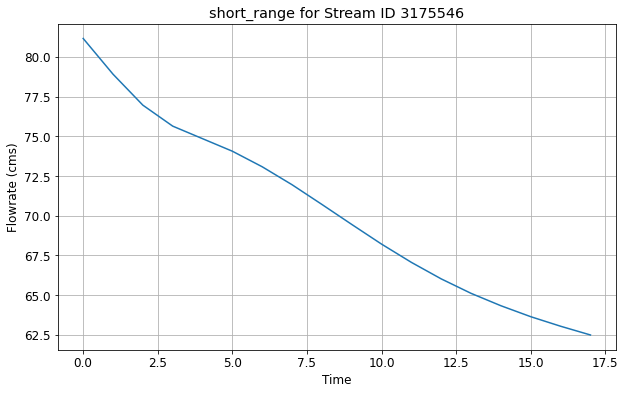

In [8]:
# This gets todays date, stores it in yyyymmdd format and assigns it to the variable 'today'
today = date.today()
today = str(today)
today = today.replace("-", "")

# Variable Notes
StreamID = 3175546                  # The unique identifier corresponding to a river segment
ForecastStartDate = today           # Today's date in YYYYMMDD format. 
ForecastStartTimestep = '00'        # Timestep forecast was issued, 00 = midnight CST
ForecastType = 'short_range'        # Options are 'short_range', 'medium_range', and 'long_range'
ForecastMember = '1'                # If using medium_range or 'long_range' then specify the ensemble member # (1-4 for long_range or 1-7 for medium_range)

#Now we use the GetSeries function from above, and provide it with the arguments as defined above.
Series = GetSeries(StreamID, ForecastStartDate, ForecastStartTimestep, ForecastType, ForecastMember)
print(Series)

# Draw a plot for the series
plt.rc('font', size=12)
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot( Series, color='tab:blue', label='Streamflow')
ax.set_xlabel('Time')
ax.set_ylabel('Flowrate (cms)')
ax.set_title(ForecastType + ' for Stream ID ' + str(StreamID))
ax.grid(True)

#This cell could take a while to run! Be patient!